In [1]:
import pandas as pd
import numpy as np

## Utils

In [2]:
def prepend_string(value: str, prefix="UNKNOWN: ") -> str:
    if pd.notna(value):
        return prefix + value
    return value

## Cleaning Nessus

In [3]:
nes = pd.read_excel('nessus.xlsx')

In [4]:
print(f'Nessus DataFrame length before cleaning: {len(nes)}')

Nessus DataFrame length before cleaning: 173


In [5]:
nes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Plugin ID                 173 non-null    int64         
 1   CVE                       36 non-null     object        
 2   CVSS v2.0 Base Score      57 non-null     float64       
 3   Risk                      56 non-null     object        
 4   Host                      173 non-null    object        
 5   Protocol                  173 non-null    object        
 6   Port                      173 non-null    int64         
 7   Name                      173 non-null    object        
 8   Synopsis                  173 non-null    object        
 9   Description               173 non-null    object        
 10  Solution                  97 non-null     object        
 11  See Also                  75 non-null     object        
 12  Plugin Output         

In [6]:
nes = nes.drop_duplicates(subset=['CVE', 'Description', 'Port'], keep='first')

In [7]:
nes['scanner'] = np.nan # This will be filled later
nes['Solution'] = nes['Solution'].apply(
    lambda solution: prepend_string(solution, prefix='NESSUS: ')
)

In [8]:
print(f'Nessus DataFrame length after cleaning: {len(nes)}')

Nessus DataFrame length after cleaning: 169


In [9]:
nes.to_excel('dedup_nessus.xlsx')

## Cleaning OpenVAS

In [10]:
vas = pd.read_excel('openvas.xlsx')

In [11]:
print(f'OpenVAS DataFrame length before cleaning: {len(vas)}')

OpenVAS DataFrame length before cleaning: 59


In [12]:
vas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   IP                              59 non-null     object 
 1   Hostname                        54 non-null     object 
 2   Port                            53 non-null     float64
 3   Port Protocol                   53 non-null     object 
 4   QoD                             59 non-null     int64  
 5   Solution Type                   59 non-null     object 
 6   NVT Name                        59 non-null     object 
 7   Summary                         59 non-null     object 
 8   Specific Result                 59 non-null     object 
 9   NVT OID                         59 non-null     object 
 10  CVEs                            35 non-null     object 
 11  Task ID                         59 non-null     object 
 12  Task Name                       59 non

In [13]:
vas = vas[vas['IP'] == '192.168.1.172'] # We will only keep this IP for this analysis.

In [14]:
vas['Port'] = vas['Port'].fillna(0).astype(int) 

In [15]:
vas = vas.drop_duplicates(subset=['CVEs', 'Summary', 'Port'], keep='first')

In [16]:
vas['scanner'] = np.nan # This will be filled later
vas['Solution'] = vas['Solution'].apply(
    lambda solution: prepend_string(solution, prefix='OPENVAS: ')
)

In [17]:
print(f'OpenVAS DataFrame length after cleaning: {len(vas)}')

OpenVAS DataFrame length after cleaning: 54


In [18]:
vas.to_excel('dedup_openvas.xlsx')

## Merging the DataFrames

In [19]:
nes = nes.rename(columns={"CVE": "CVEs"})

Here we will merge the intersection between OpenVAS and Nessus.

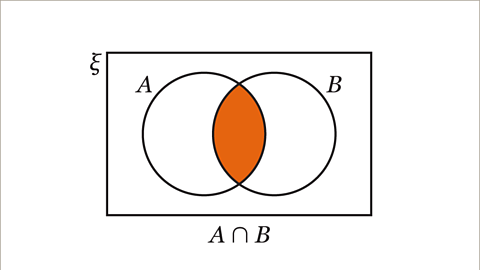

In [20]:
# Merge DataFrames on 'CVEs' and 'Port' where both columns are not empty
merged_df = pd.merge(
    vas[(vas['CVEs'].notna()) & (vas['Port'].notna())],
    nes[(nes['CVEs'].notna()) & (nes['Port'].notna())],
    on=['CVEs', 'Port'],
    how='inner'
)
merged_df['Scanner'] = 'NESSUS,OPENVAS'

In [21]:
merged_df

,IP,Hostname,Port,Port Protocol,QoD,Solution Type,NVT Name,Summary,Specific Result,NVT OID,...,BID,XREF,MSKB,Plugin Publication Date,Plugin Modification Date,Metasploit,Core Impact,CANVAS,scanner_y,Scanner
0,192.168.1.172,METASPLOITABLE,5432,tcp,80,Mitigation,SSL/TLS: SSLv3 Protocol CBC Cipher Suites Info...,This host is prone to an information disclosur...,Vulnerability was detected according to the Vu...,1.3.6.1.4.1.25623.1.0.802087,...,70574,CERT:577193,NaN,2014-10-15,2023-06-23,NaN,NaN,NaN,NaN,"NESSUS,OPENVAS"
1,192.168.1.172,METASPLOITABLE,8009,tcp,99,VendorFix,Apache Tomcat AJP RCE Vulnerability (Ghostcat),Apache Tomcat is prone to a remote code execut...,"It was possible to read the file ""/WEB-INF/web...",1.3.6.1.4.1.25623.1.0.143545,...,NaN,CISA-KNOWN-EXPLOITED:2022/03/17;CEA-ID:CEA-202...,NaN,2020-03-24,2024-07-17,NaN,NaN,NaN,NaN,"NESSUS,OPENVAS"
2,192.168.1.172,METASPLOITABLE,0,NaN,80,Mitigation,ICMP Timestamp Reply Information Disclosure,The remote host responded to an ICMP timestamp...,The following response / ICMP packet has been ...,1.3.6.1.4.1.25623.1.0.103190,...,NaN,CWE:200,NaN,1999-08-01,2024-05-03,NaN,NaN,NaN,NaN,"NESSUS,OPENVAS"


Now that the intersection is merged, we want to get the difference for both A and B (A ∩ B' and A' ∩ B).

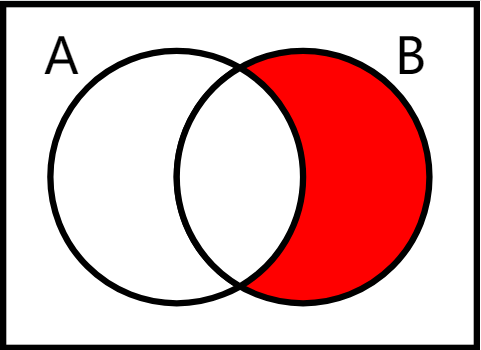

In [22]:
def get_difference(
    A: pd.DataFrame,
    intersection: pd.DataFrame,
    columns: list[str]
) -> pd.DataFrame:
    '''
    This function essentially returns the difference between a given DataFrame A
    and its intersection with another DataFrame.
    (https://byjus.com/maths/difference-of-sets/)
    '''

    # We will merge to a dataset and check how it was merged. If the columns match,
    # then the row will be indicated as "both", and if not, then it will be "left_only"
    merged_df = A.merge(
        intersection[columns],
        on=columns,
        how='left',
        indicator=True
    )

    # We will keep only the rows which keys were not present in both as those are duplicates
    difference = merged_df[merged_df['_merge'] != 'both']
    return difference.drop(columns=['_merge'])

In [23]:
vas_not_merged = get_difference(vas, merged_df, columns=['CVEs', 'Port'])
nes_not_merged = get_difference(nes, merged_df, columns=['CVEs', 'Port'])

In [24]:
vas_not_merged['Scanner'] = 'OPENVAS'
nes_not_merged['Scanner'] = 'NESSUS'

Now if we concatenate the difference with the intersection, we will get the whole set, deduplicated.

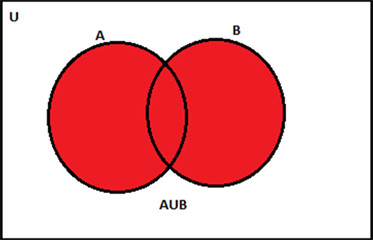

In [25]:
df = pd.concat([merged_df, vas_not_merged, nes_not_merged], ignore_index=True)

In [26]:
df.head(3)

,IP,Hostname,Port,Port Protocol,QoD,Solution Type,NVT Name,Summary,Specific Result,NVT OID,...,MSKB,Plugin Publication Date,Plugin Modification Date,Metasploit,Core Impact,CANVAS,scanner_y,Scanner,Solution,scanner
0,192.168.1.172,METASPLOITABLE,5432,tcp,80.0,Mitigation,SSL/TLS: SSLv3 Protocol CBC Cipher Suites Info...,This host is prone to an information disclosur...,Vulnerability was detected according to the Vu...,1.3.6.1.4.1.25623.1.0.802087,...,NaN,2014-10-15,2023-06-23,NaN,NaN,NaN,NaN,"NESSUS,OPENVAS",NaN,NaN
1,192.168.1.172,METASPLOITABLE,8009,tcp,99.0,VendorFix,Apache Tomcat AJP RCE Vulnerability (Ghostcat),Apache Tomcat is prone to a remote code execut...,"It was possible to read the file ""/WEB-INF/web...",1.3.6.1.4.1.25623.1.0.143545,...,NaN,2020-03-24,2024-07-17,NaN,NaN,NaN,NaN,"NESSUS,OPENVAS",NaN,NaN
2,192.168.1.172,METASPLOITABLE,0,NaN,80.0,Mitigation,ICMP Timestamp Reply Information Disclosure,The remote host responded to an ICMP timestamp...,The following response / ICMP packet has been ...,1.3.6.1.4.1.25623.1.0.103190,...,NaN,1999-08-01,2024-05-03,NaN,NaN,NaN,NaN,"NESSUS,OPENVAS",NaN,NaN


## Cleaning concatenated DataFrame

In [27]:
df = df.drop(columns=['scanner_x', 'scanner_y'])

In [28]:
df['IP'] = df['IP'].fillna(df['Host'])
df = df.drop(columns='Host')

In [29]:
df['Name'] = df['Name'].fillna(df['NVT Name'])
df = df.drop(columns='NVT Name')

In [30]:
def merge_solutions(row: pd.Series) -> str:
    """
    Function to determine the value of the 'Solution' column based on the logic provided.
    """
    solution = row['Solution']
    solution_y = row['Solution_y']
    
    if pd.notna(solution) and pd.notna(solution_y) and not solution_y == solution:
        return solution + "\n\n" + solution_y
    elif pd.notna(solution):
        return solution
    return solution_y

In [31]:
df['Solution'] = df['Solution'].combine_first(df['Solution_y'])
df['Solution'] = df.apply(merge_solutions, axis=1)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   IP                              220 non-null    object        
 1   Hostname                        54 non-null     object        
 2   Port                            220 non-null    int64         
 3   Port Protocol                   51 non-null     object        
 4   QoD                             54 non-null     float64       
 5   Solution Type                   54 non-null     object        
 6   Summary                         54 non-null     object        
 7   Specific Result                 54 non-null     object        
 8   NVT OID                         54 non-null     object        
 9   CVEs                            67 non-null     object        
 10  Task ID                         54 non-null     object        
 11  Task N